In [1]:
import pandas as pd
import numpy as np
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Load Data
df = pd.read_csv('agg_data/conv_traf.csv')
df

,fullVisitorId,date,conversion,convSoFar,value,source,medium,channelGrouping,isTrueDirect,newVisitor,isNewVisit,isFirstConversion
0,1235242196175467,2016-11-01,0,0,NaN,baidu,organic,Organic Search,NaN,1.0,1.0,0
1,15980521034237800,2016-12-08,0,0,NaN,facebook.com,referral,Social,NaN,1.0,1.0,0
2,34572692224994048,2016-10-03,0,0,NaN,baidu,organic,Organic Search,NaN,1.0,1.0,0
3,40335064426021006,2016-08-31,0,0,NaN,phandroid.com,referral,Referral,NaN,1.0,1.0,0
4,47788902811115718,2016-12-14,0,0,NaN,adwords.google.com,referral,Referral,NaN,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
903648,9981048921160614325,2017-01-09,0,0,NaN,youtube.com,referral,Social,NaN,1.0,1.0,0
903649,9983899559058751167,2016-10-08,0,0,NaN,youtube.com,referral,Social,NaN,1.0,1.0,0
903650,9985652375912834608,2016-10-22,0,0,NaN,youtube.com,referral,Social,NaN,1.0,1.0,0
903651,998979252829558548,2017-04-27,0,0,NaN,youtube.com,referral,Social,NaN,1.0,1.0,0


In [2]:
# Fill na with 0
df = df.fillna(0)

In [3]:
# Redefine the medium column based on their definitions
map_dictionary = {'organic': 'Search', '(none)': 'Direct', 
                  'referral': 'Referral', 'cpc':'Paid Search', 
                  'affiliate': 'Affiliate', 'cpm': 'Display Ad', '(not set)': 'Direct'}

df['medium'] = df['medium'].map(map_dictionary)

df['medium'].value_counts()

medium
Direct         371584
Referral       262022
Search         234381
Affiliate       16403
Paid Search     13079
Display Ad       6184
Name: count, dtype: int64

# Medium Variance over Time

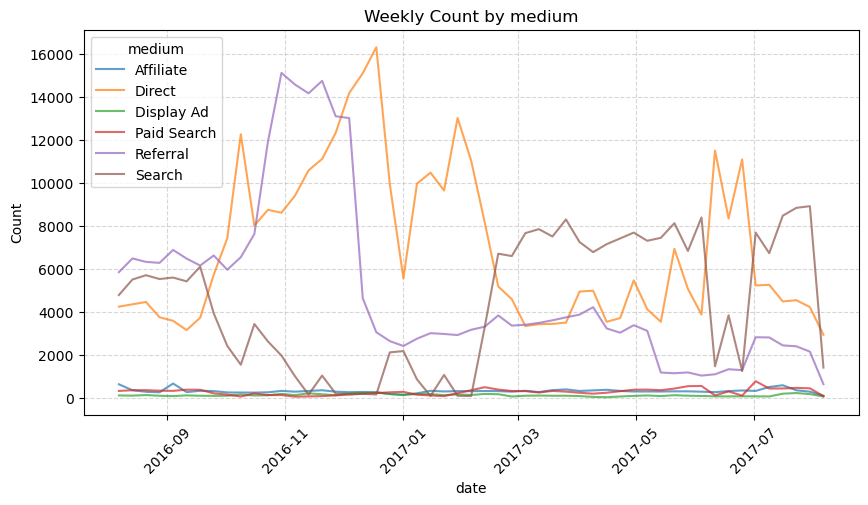

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Resample to weekly data
grouped_weekly = df.groupby([pd.Grouper(key='date', freq='W'), 'medium']).agg({'fullVisitorId': 'count', 'value' : 'sum', 'conversion' : 'sum'}).reset_index()


def weekly_plot_by_medium(data = grouped_weekly, by = 'medium', col= 'fullVisitorId', title = 'Count'):
    # Define the desired legend order
    if by == 'medium':
        medium_order = ["Affiliate", "Direct", "Display Ad", "Paid Search", "Referral", "Search"]
    else:
        medium_order = None
        
    # Create the line plot with the specified order
    plt.figure(figsize=(10, 5))  # Adjust figure size if needed
    sns.lineplot(
        data= data, 
        x='date', 
        y= col, 
        hue= by, 
        hue_order=medium_order,  # Ensures consistent legend order
        linewidth=1.5, 
        alpha=0.7
    )

    # Format x-axis ticks
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.ylabel(title)
    plt.title(f'Weekly {title} by {by}')

    # Add a grid for better visualization
    plt.grid(True, linestyle='--', alpha=0.5)

    # Show the plot
    plt.show()

weekly_plot_by_medium(col = 'fullVisitorId')


Unable to investigate yearly pattern. However, weekly count of visits from direct and search seems to be negatively correlated. Referral's attraction drops across the year, potentially where visitors search the about the company which leads to the company website and saved the website for future visits, and so the search number decreases where the source users transferred to using the direct source. Conversely, around 2017-02, when direct uses dropped, the company may have increased advertisements (paid search, and display ads) or promotions and increased exposure of the company offline.

However, the visits from referral dropped overtime, likely due to the number of visitors the company's partners' and existing customers' referred is limited, and the speed of referral is much quicker than the increase in new connections from the partners and customers.

In [5]:
from scipy.stats import pearsonr

statistics, pvalue = pearsonr(grouped_weekly.loc[grouped_weekly['medium'] == 'Direct', 'fullVisitorId'], grouped_weekly.loc[grouped_weekly['medium'] == 'Search', 'fullVisitorId'])
if pvalue <= 0.01:
    print(f"Pearson Correlation Test shows significant evident between weekly visits from 'Direct' and 'Search', with the Pearson Correlation Coefficient {statistics}.")

Pearson Correlation Test shows significant evident between weekly visits from 'Direct' and 'Search', with the Pearson Correlation Coefficient -0.84041435328884.


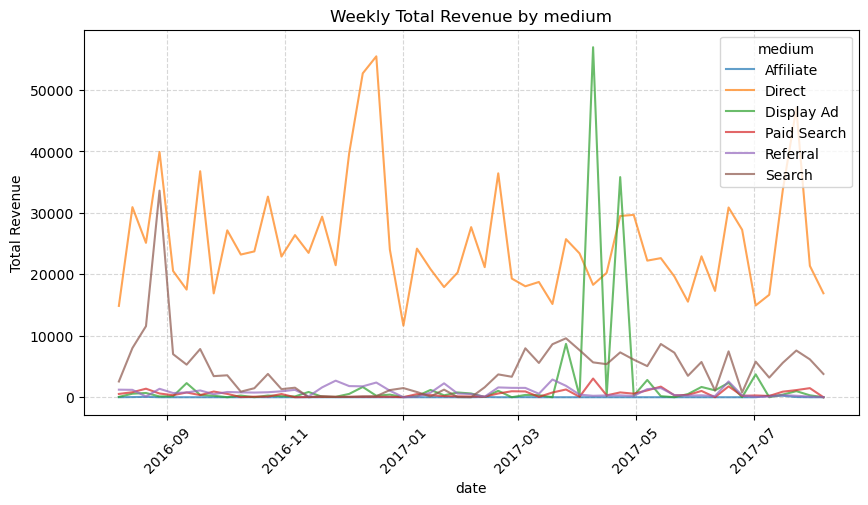

In [6]:
weekly_plot_by_medium(col = 'value', title = 'Total Revenue')

Only 'Direct' and 'Search' has the most consistent weekly revenue. In addition, there is a spike in revenue between 2017-MAR till 2017-MAY from display ad, potentially an anomaly or some event occured, but we are unable to track it.

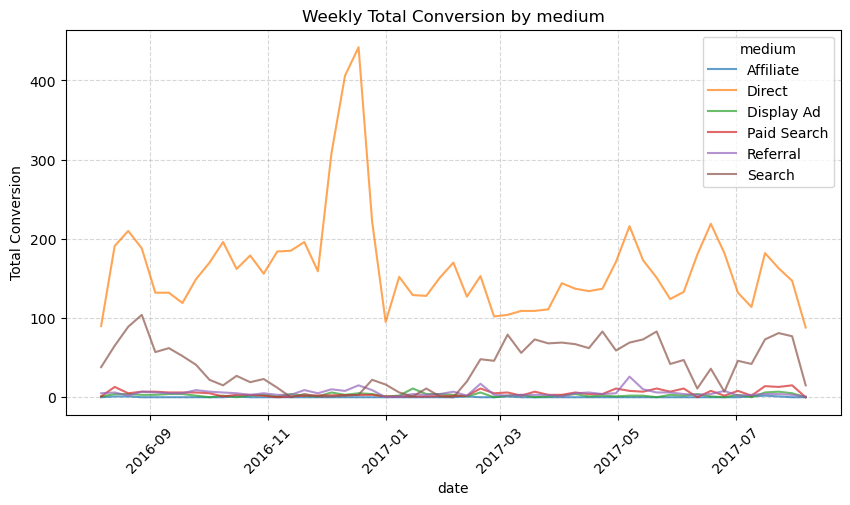

In [7]:
weekly_plot_by_medium(col = 'conversion', title = 'Total Conversion')

Consistent weekly total conversions for 'Direct', but it doesn't seem to correlate with the weekly visits. 'Search' has a drop in conversion from 2016-09 till 2017-02, and this correlated with the weekly visits from 'Search', and it increases onwards. 

# Specific Source Comparisons

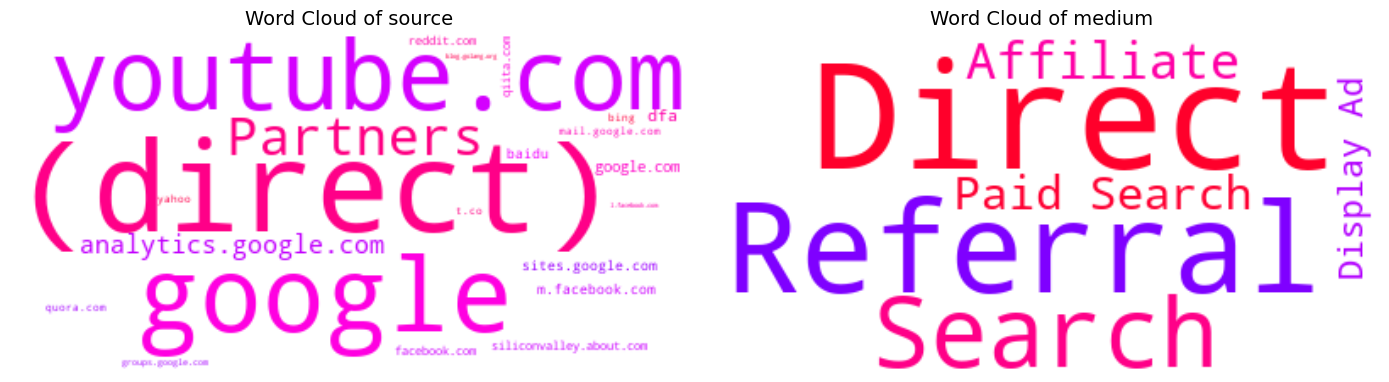

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import random

# Rainbow Coloring Function
def rainbow_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    hue = random.randint(270, 350)  # Random hue for rainbow effect
    return f"hsl({hue}, 100%, 50%)"  # Full saturation and medium brightness for vibrant colors

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

for i, col in enumerate(['source', 'medium']):
    # Count unique words
    word_counts = Counter(df[col].tolist())

    # Generate WordCloud using frequency dictionary
    wordcloud = WordCloud(max_words=30, background_color="white").generate_from_frequencies(word_counts)

    # Plot in subplot
    axes[i].imshow(wordcloud.recolor(color_func=rainbow_color_func, random_state=3), interpolation='bilinear')
    axes[i].set_title(f'Word Cloud of {col}', fontsize=14)
    axes[i].axis("off")  # Hide axes

# Adjust layout
plt.tight_layout()
plt.show()

The word cloud for medium has referral as the main medium, but looking at the sources, Partners and dfa contribute much less than direct and google. This indicates that some customers might have click off the site and re-entered them directly after some time.

In [9]:
# Function to categorize sources based on link
def categorize_source(source):
    source = str(source).lower()  # Convert to lowercase for consistency
    
    if 'google' in source:
        return 'Google'
    elif 'youtube' in source:
        return 'YouTube'
    elif 'facebook' in source:
        return 'Facebook'
    elif 'reddit' in source:
        return 'Reddit'
    elif 'quora' in source:
        return 'Quora'
    elif 'dfa' in source:
        return 'dfa'
    elif 'Partners' in source:
        return 'Partners'
    else:
        return 'Other'  # Default category for unknown sources

# Apply categorization function to the 'source' column
df['source_category'] = df['source'].apply(categorize_source)

# Value count
df['source_category'].value_counts()

source_category
Other       404331
Google      270764
YouTube     212697
Facebook      6523
dfa           5686
Reddit        2106
Quora         1546
Name: count, dtype: int64

In [10]:
# Revenue proportion by sources category
(df.groupby('source_category')['value'].sum()/df['value'].sum()).sort_values( ascending = False)

source_category
Other       0.754945
Google      0.169356
dfa         0.072346
Facebook    0.003126
YouTube     0.000199
Quora       0.000018
Reddit      0.000010
Name: value, dtype: float64

In [11]:
# Summarize revenue and conversion by source categories
summary_df = df.groupby('source_category').agg(
                total_revenue = ('value', 'sum'),
                total_visits = ('fullVisitorId', 'count'),
                total_conversions = ('conversion', 'sum')
            )
summary_df['revenue per conversion'] = round(summary_df['total_revenue']/summary_df['total_conversions'],2)
summary_df['conversion rate'] = round(summary_df['total_conversions']/summary_df['total_visits'] *100, 2)
summary_df

,total_revenue,total_visits,total_conversions,revenue per conversion,conversion rate
source_category,,,,,
Facebook,5564.43,6523,39,142.68,0.60
Google,301479.64,270764,2503,120.45,0.92
Other,1343913.99,404331,8873,151.46,2.19
Quora,31.98,1546,1,31.98,0.06
Reddit,16.97,2106,1,16.97,0.05
YouTube,355.07,212697,11,32.28,0.01
dfa,128787.15,5686,124,1038.61,2.18


The table presents data on various source categories, showing that Google and Other drive a large number of visits but have relatively low revenue per conversion. Google, in particular, stands out with the highest visits, yet the revenue per conversion is much lower compared to other sources. This suggests that while these sources have the potential to attract a high volume of new visitors, they may not be as efficient at converting those visitors into high-value actions. However, their consistent traffic flow and relatively steady revenue streams make them valuable for maintaining a broad presence online, even if their individual conversion efficiency isn't as high.

In contrast, dfa exhibits a much higher revenue per conversion, indicating a more effective return on investment for every successful conversion. With a conversion rate similar to Other, it demonstrates solid potential for generating substantial revenue with fewer but higher-value conversions. 

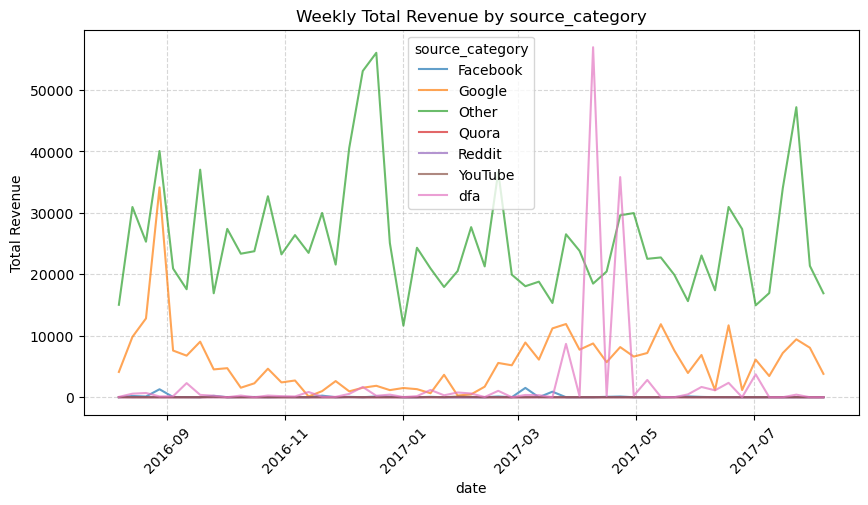

In [12]:
# Source Category Revenue
cat_weekly = df.groupby([pd.Grouper(key='date', freq='W'), 'source_category']).agg({'fullVisitorId' : 'count', 'value' : 'sum', 'conversion' : 'mean'}).reset_index()
cat_weekly['revenue per visit'] = cat_weekly['value']/cat_weekly['fullVisitorId']

# Plot
weekly_plot_by_medium(data = cat_weekly, by = 'source_category', col = 'value', title = 'Total Revenue')

Dfa contributes majority of display ad's revenue The cost of each source for advertisement or referral is unknown, hence the decision to relocate budget from low return per cost and return per impression. But we can assess revenue per visit and conversion rate.

Putting the graph with the previous weekly total revenue by medium side by side, there are the following correlations:

- Other -> Direct
- Google -> Both Search and Paid Search
- dfa -> Display Ads
- YouTube, Quora, Facebook, Reddit -> Affliate, Paid Search, Display Ads


The risk with dfa lies in its inconsistency; the revenue spike observed during a specific month suggests that the source generates revenue in bursts rather than continuously throughout the year. This pattern introduces volatility and makes dfa a more risky investment, as its performance can fluctuate significantly between periods.

# Time Series Model for Direct Revenue

Given the consistent pattern in weekly revenue generated by Google throughout the year, it allows forecast in future revenue with a time series model. First, check all the assumptions for the model fit.

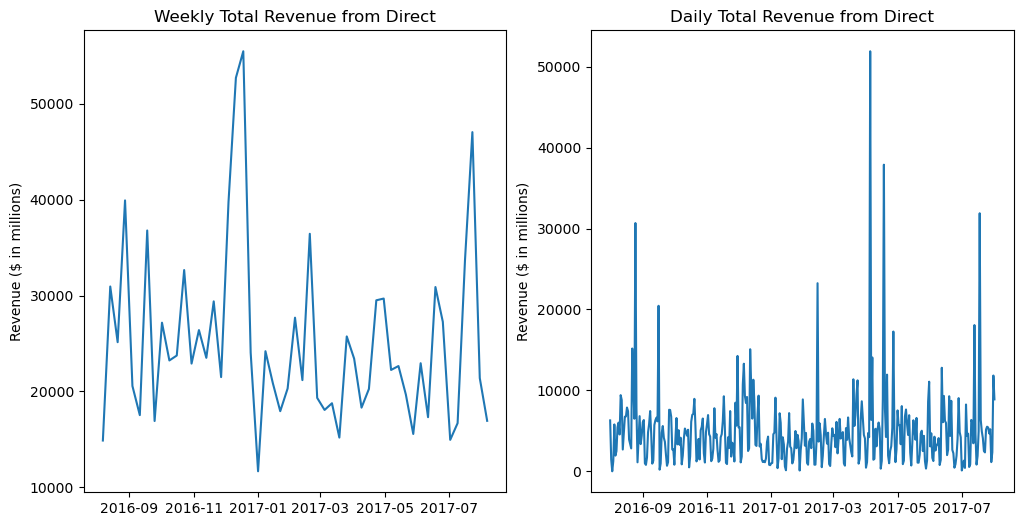

In [13]:
# Filter data
daily_df = df.groupby('date')['value'].sum().to_frame()
daily_df.columns = ['revenue']

# Filter data from Direct Transactions
weekly_df = df[df['medium'] == 'Direct'].groupby(pd.Grouper(key = 'date', freq = 'W'))['value'].sum().to_frame()
weekly_df.columns = ['revenue']

# Subplot
fig, ax = plt.subplots(1,2, figsize = (12,6))

# Visualise weekly revenue pattern
ax[0].plot(weekly_df.index, weekly_df['revenue'])
ax[0].set_title('Weekly Total Revenue from Direct')
ax[0].set_ylabel('Revenue ($ in millions)')


# Visualise daily revenue pattern
ax[1].plot(daily_df.index, daily_df['revenue'])
ax[1].set_title('Daily Total Revenue from Direct')
ax[1].set_ylabel('Revenue ($ in millions)')



# Display the subplot
fig.show()

The fluctuation in revenue across the year is not extremely volatile, a possible sign of stationarity in this time series.

In [14]:
from statsmodels.tsa.stattools import adfuller

# Check Stationarity in the time series
results = adfuller(weekly_df)

print(f'The resulting ADF Test Statistic in weekly revenue is {results[0]} with p-value {results[1]}')

# Check Stationarity in the time series
results = adfuller(daily_df)

print(f'The resulting ADF Test Statistic in daily revenue is {results[0]} with p-value {results[1]}')


The resulting ADF Test Statistic in weekly revenue is -4.87849916461798 with p-value 3.8395544893474614e-05
The resulting ADF Test Statistic in daily revenue is -3.260546428067882 with p-value 0.016736833587860905


The results suggested the time series is stationary, and appropriate for fitting time series models.

Lags where ACF goes above threshold: [0]
Lags where PACF goes above threshold: [0]


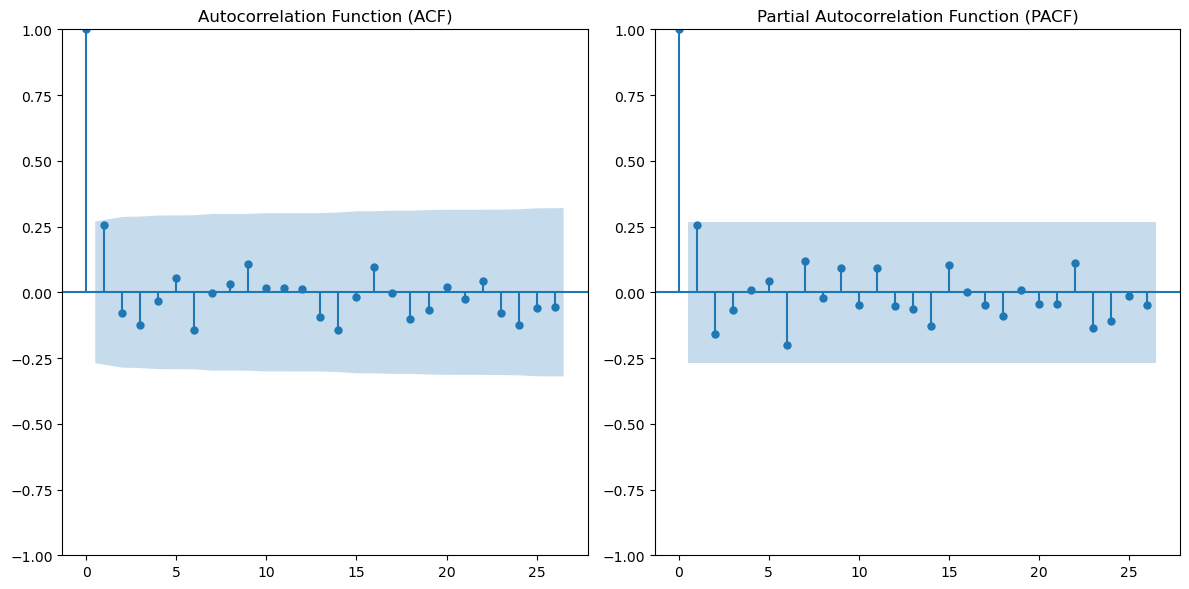

Lags where ACF goes above threshold: [0, 1, 7, 8, 10, 13, 14, 17, 18, 21, 22, 23, 24, 28, 31, 34, 35, 38, 39, 42, 45, 46, 49, 50, 51, 52, 53, 56, 59, 60, 63, 66, 67, 70, 73, 74, 77, 79, 80, 81, 84, 87, 91, 93, 94, 99, 101, 104, 105, 111, 112, 119, 120, 126, 133, 154, 164, 171]
Lags where PACF goes above threshold: [0, 1, 7, 10, 13, 22, 26, 28, 44, 79, 91, 93, 96, 104, 114, 120, 131, 151, 157, 160, 162, 165, 167, 168, 169, 174, 176, 177, 179, 181, 182]


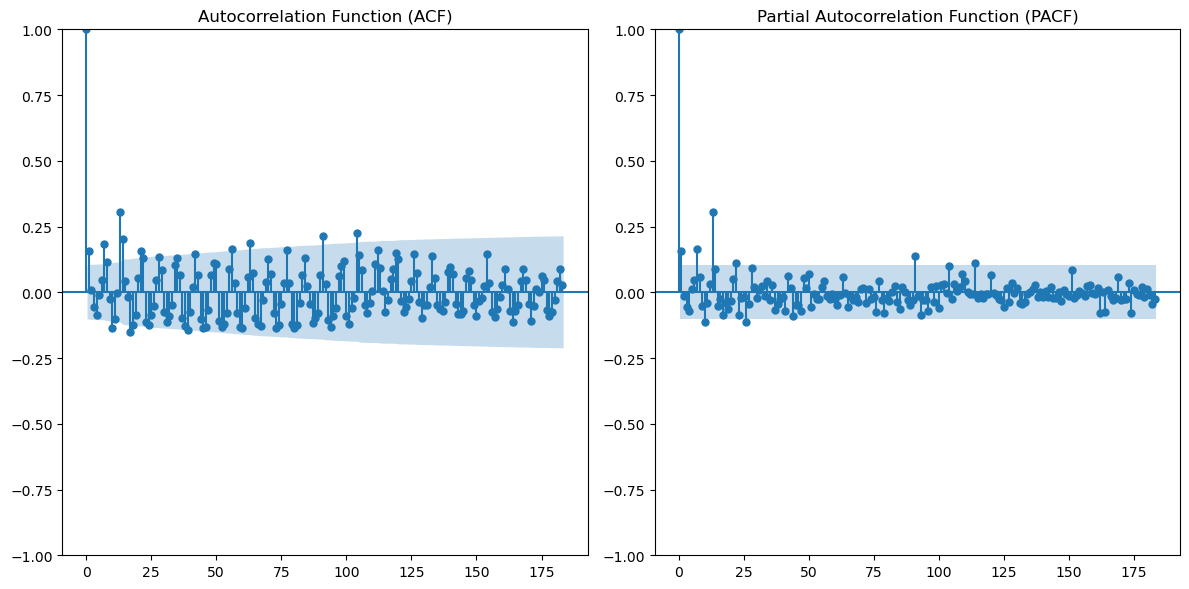

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

def auto_plots(df):
    n = len(df)  # Length of the time series
    confidence_level = 1.96 / np.sqrt(n)  # 95% confidence interval for ACF and PACF
    
    # Calculate ACF and PACF values
    acf_values, acf_confint = acf(df['revenue'], nlags=n//2, alpha=0.05)  # Calculate ACF values
    pacf_values, pacf_confint = pacf(df['revenue'], nlags=n//2, alpha=0.05)  # Calculate PACF values

    # Identify lags where ACF goes above the threshold
    acf_above_threshold = [i for i in range(len(acf_values)) if abs(acf_values[i]) > confidence_level]
    pacf_above_threshold = [i for i in range(len(pacf_values)) if abs(pacf_values[i]) > confidence_level]

    # Print the lags that go over the threshold
    print(f"Lags where ACF goes above threshold: {acf_above_threshold}")
    print(f"Lags where PACF goes above threshold: {pacf_above_threshold}")
    
    # Create subplots with desired figure size and axes
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns, figure size 12x6 inches

    # Plot ACF on the first subplot
    plot_acf(df['revenue'], lags=n//2, ax=ax[0], alpha=0.05)  # Pass the first axis (ax[0]) to the ACF plot
    ax[0].set_title("Autocorrelation Function (ACF)")  # Set title for ACF plot

    # Plot PACF on the second subplot
    plot_pacf(df['revenue'], lags=n//2, ax=ax[1], alpha=0.05)  # Pass the second axis (ax[1]) to the PACF plot
    ax[1].set_title("Partial Autocorrelation Function (PACF)")  # Set title for PACF plot

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Call the function with weekly and daily data
auto_plots(weekly_df)
auto_plots(daily_df)


For weekly revenue, there is no significant autocorrelation and partial autocorrelation values over the threshold from the lags, apart from the first lag, there is no significant lag dependency within this time series.

For daily revenue, there are significant lag dependencies, in particular, the first lag and seventh lag, indicating the revenue generated has dependencies to the revenue from yesterday and the same week day two weeks before.

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model for weekly revenue
weekly_model = ARIMA(weekly_df, order=(1,0,0))  
weekly_model_fit = weekly_model.fit()

# Print the summary to view details
print(weekly_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                   53
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -556.915
Date:                Fri, 28 Mar 2025   AIC                           1119.830
Time:                        17:31:51   BIC                           1125.741
Sample:                    08-07-2016   HQIC                          1122.103
                         - 08-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.514e+04   1833.878     13.711      0.000    2.15e+04    2.87e+04
ar.L1          0.2629      0.100      2.634      0.008       0.067       0.458
sigma2      7.794e+07      0.093   8.37e+08      0.0

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import aic, bic

# Define orders to test
orders = [(1, 1, 0), (7, 1, 0), (10, 1, 0)]
results = {}

# Fit models and store AIC & BIC
for order in orders:
    model = SARIMAX(daily_df['revenue'], order=order, seasonal_order=(0, 1, 1, 7))
    model_fit = model.fit()
    results[order] = (model_fit.aic, model_fit.bic)  # Store both AIC and BIC

# Print results sorted by AIC
sorted_results = sorted(results.items(), key=lambda x: x[1][0])  # Sort by AIC

for order, (aic_value, bic_value) in sorted_results:
    print(f"Order {order} -> AIC: {aic_value:.3f}, BIC: {bic_value:.3f}")


c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

Order (7, 1, 0) -> AIC: 7093.139, BIC: 7128.064
Order (10, 1, 0) -> AIC: 7113.435, BIC: 7160.001
Order (1, 1, 0) -> AIC: 7165.558, BIC: 7177.200


The seasonal ARIMA model in order (7,1,0) with seasonal order (0,1,1,7) has the lowest AIC and BIC value to the other models, it provides the best balance between complexity and accuracy for describing daily revenue from direct visits.

In [18]:
# Check model summary
best_model = SARIMAX(daily_df, order=(7,1,0), seasonal_order=(0, 1, 1, 7)).fit()
best_model.summary()

c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             revenue   No. Observations:                  366
Model:             SARIMAX(7, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -3537.569
Date:                             Fri, 28 Mar 2025   AIC                           7093.139
Time:                                     17:31:55   BIC                           7128.064
Sample:                                 08-01-2016   HQIC                          7107.029
                                      - 08-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8224      0.045    -18.334      0.000      -0.910      -0.734
ar.L2         -0.6342      0.063     -9.994      0.000      -0.759      -0.510
ar.L3         -0.4706      0.065     -7.283      0.000      -0.597      -0.344
ar.L4         -0.3553      0.069     -5.170      0.000      -0.490      -0.221
ar.L5         -0.2270      0.067     -3.381      0.001      -0.359      -0.095
ar.L6         -0.2214      0.063     -3.531      0.000      -0.344      -0.098
ar.L7         -0.1416      0.053     -2.670      0.008      -0.246      -0.038
ma.S.L7       -0.9837      0.026    -37.515      0.000      -1.035      -0.932
sigma2       2.13e+07   2.32e-09   9.18e+15      0.000    2.13e+07    2.13e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):             21854.45
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               3.54   Skew:                             4.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+29. Standard errors may be unstable.
"""

All the coefficients has p-value < 0.01 based on their Z-test, therefore each coefficient is significant in describing daily revenue. 

Furthermore, the result of the Ljung-Box test indicates there is no significant autocorrelation within the residuals at lag 1, which suggests the model has adequately captured the temporal dependencies within daily revenue.

The Jarque-Bera test, which checks for normality of the residuals, is indicating that the residuals are not normally distributed. This is confirmed by the presence of skewness and kurtosis values that suggest non-normality in the residuals (e.g., high kurtosis means fat tails, and skewness indicates asymmetry).

There is heteroskedasticity presenting in the residual of the model fit. This suggests that the variance of the errors changes over time. In the context of daily revenue, this could indicate that the volatility (uncertainty) of daily revenue is not constant, likely due to factors like sales, promotions, or holidays, which cause large fluctuations in revenue.

## log-transformation

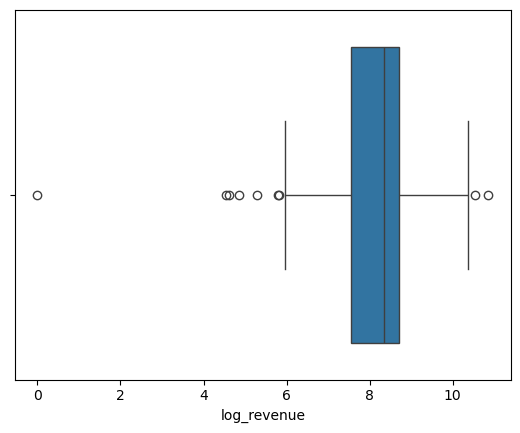

In [19]:
import numpy as np

# log Transform the data 
daily_df['log_revenue'] = np.log(daily_df['revenue'] + 1) 

# Plot boxplot of transformed data
sns.boxplot(data = daily_df, x = daily_df['log_revenue'])
plt.show()

For better model fit, impute outlier (0) by previous revenues, which ensures time series consistency and avoiding data leakage.

In [20]:
# Reset index
daily_df =  daily_df.reset_index()

# Calculate mean revenue before 0 revenue and then log-transform
date = daily_df.loc[daily_df['log_revenue'] == 0, 'date'].to_list()[0]
mean = np.log(daily_df.loc[daily_df['date'] < date, 'revenue'].mean())

# Impute 0 but the mean of previous revenue
daily_df.loc[daily_df['log_revenue'] == 0, 'log_revenue'] = mean

# Set date as index
daily_df.set_index('date', inplace = True)



In [21]:
# Fit a seasonal model on the transformed revenue
log_model_fit = SARIMAX(daily_df['log_revenue'], order=(7, 1, 0), seasonal_order=(0, 1, 1, 7)).fit()

# Model summary
log_model_fit.summary()

c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         log_revenue   No. Observations:                  366
Model:             SARIMAX(7, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -346.035
Date:                             Fri, 28 Mar 2025   AIC                            710.069
Time:                                     17:31:57   BIC                            744.994
Sample:                                 08-01-2016   HQIC                           723.959
                                      - 08-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7277      0.057    -12.788      0.000      -0.839      -0.616
ar.L2         -0.5888      0.069     -8.587      0.000      -0.723      -0.454
ar.L3         -0.4624      0.077     -5.976      0.000      -0.614      -0.311
ar.L4         -0.3446      0.070     -4.913      0.000      -0.482      -0.207
ar.L5         -0.1975      0.080     -2.470      0.014      -0.354      -0.041
ar.L6         -0.2562      0.070     -3.652      0.000      -0.394      -0.119
ar.L7         -0.1440      0.064     -2.259      0.024      -0.269      -0.019
ma.S.L7       -0.9990      1.076     -0.929      0.353      -3.108       1.110
sigma2         0.3740      0.394      0.950      0.342      -0.398       1.146
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                51.07
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.00
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

After log-transformation, skewness and heteroskedasticity diminished, but the normality in residual does not present based on the Jarque-Bera statisitcs, where the exterme revenue remains extreme.

The coefficients are significant in describing the temporal dependencies in log-revenue, except for the order 5 and order 7 autoregressive terms, where its Z statistic is only significant in 5\% significance level.

The Z-tests suggest the seasonal term is not significant in describing the log-revenue, fit alternate model and compare AIC.

In [22]:
# Fit another model without the unsignificant seasonal term
alter_model_fit = SARIMAX(daily_df['log_revenue'], order=(7, 1, 0), seasonal_order=(0, 1, 0, 7)).fit()

# Model AIC
print(f'The model without the seasonal term has AIC {alter_model_fit.aic}')

c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\edwin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


The model without the seasonal term has AIC 846.420588371524


Must keep the seasonal term for better performance with the increase in AIC without the seasonal term.

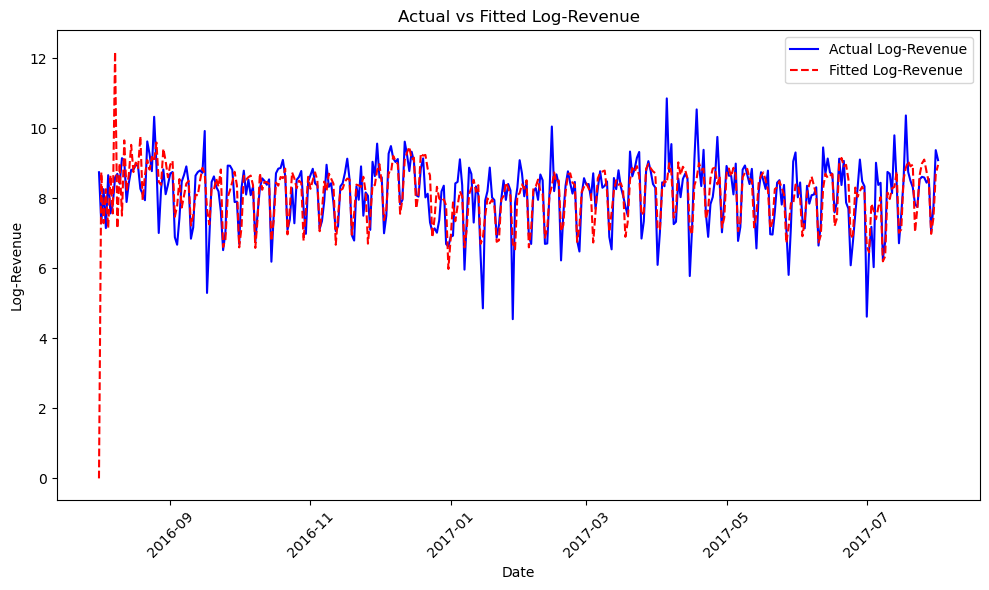

Log-Transformed Model - RMSE: 0.8164, R²: 0.2111


In [23]:
from sklearn.metrics import mean_squared_error, r2_score

# Get fitted values from the log-revenue model
log_fitted_values = log_model_fit.fittedvalues

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the actual log_revenue vs fitted log_revenue
plt.plot(daily_df.index, daily_df['log_revenue'], label='Actual Log-Revenue', color='blue')
plt.plot(daily_df.index, log_fitted_values, label='Fitted Log-Revenue', color='red', linestyle='--')

# Add labels and title
plt.title('Actual vs Fitted Log-Revenue')
plt.xlabel('Date')
plt.ylabel('Log-Revenue')
plt.legend(loc='best')

# Show the plot with proper x-tick rotation
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# For Log-Transformed Model (Back-transformed fitted values)
log_rmse = np.sqrt(mean_squared_error(daily_df['log_revenue'], log_fitted_values))
log_r2 = r2_score(daily_df['log_revenue'], log_fitted_values)
print(f"Log-Transformed Model - RMSE: {log_rmse:.4f}, R²: {log_r2:.4f}")

 The initial predictions of the model is inaccurate, but the rest seems to to be adequately fitted.

Comparison of Model Performance:
Log-Transformed Model - RMSE: 11026.6868, R²: -4.0818
Raw Revenue Model - RMSE: 4686.1379, R²: 0.0822


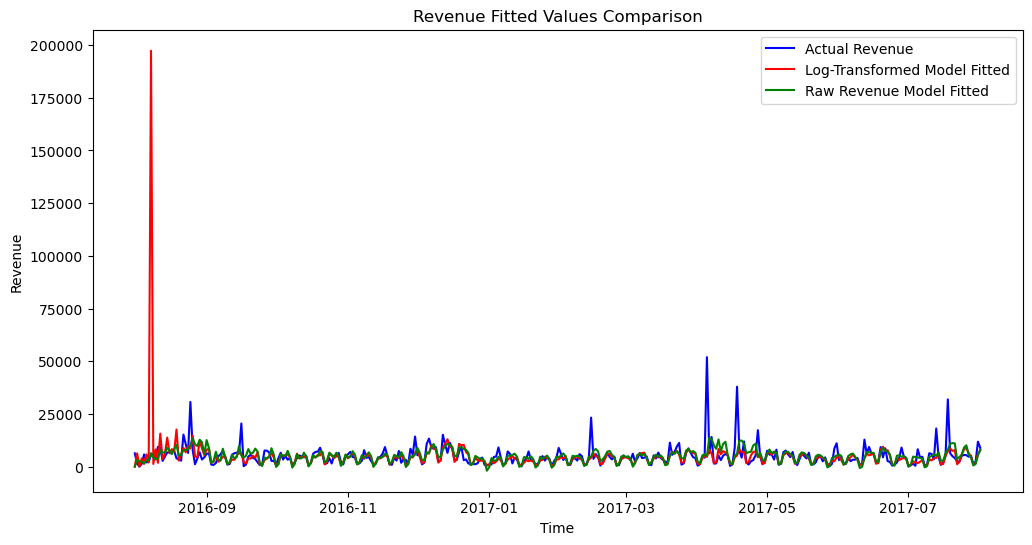

In [24]:
# Get fitted values from the log-revenue model
log_fitted_values = log_model_fit.fittedvalues
log_fitted_values_backtransformed = np.exp(log_fitted_values) - 1  # Back-transform
log_fitted_values_backtransformed[2] = 0

# Get fitted values from the best model on daily revenue
daily_fitted_values = best_model.fittedvalues

# Compare predicted values
# For Log-Transformed Model (Back-transformed fitted values)
log_rmse = np.sqrt(mean_squared_error(daily_df['revenue'], log_fitted_values_backtransformed))
log_r2 = r2_score(daily_df['revenue'], log_fitted_values_backtransformed)

# For Raw Revenue Model
daily_rmse = np.sqrt(mean_squared_error(daily_df['revenue'], daily_fitted_values))
daily_r2 = r2_score(daily_df['revenue'], daily_fitted_values)


# Print out the comparison of both models
print("Comparison of Model Performance:")
print(f"Log-Transformed Model - RMSE: {log_rmse:.4f}, R²: {log_r2:.4f}")
print(f"Raw Revenue Model - RMSE: {daily_rmse:.4f}, R²: {daily_r2:.4f}")

# Plot the fitted values for comparison
plt.figure(figsize=(12, 6))
plt.plot(daily_df['revenue'], label='Actual Revenue', color='blue')
plt.plot(log_fitted_values_backtransformed, label='Log-Transformed Model Fitted', color='red')
plt.plot(daily_fitted_values, label='Raw Revenue Model Fitted', color='green')
plt.legend()
plt.title('Revenue Fitted Values Comparison')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.show()


In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define the starting index to cut off initial values (for example, from index 30 onward)
cut_off_index =  10

# Log-Transformed Model - Fitted Values (Back-Transformed)
log_fitted_values_backtransformed_cutoff = log_fitted_values_backtransformed[cut_off_index:]
log_actual_values_cutoff = daily_df['revenue'][cut_off_index:]

# Raw Revenue Model - Fitted Values
daily_fitted_values_cutoff = daily_fitted_values[cut_off_index:]
daily_actual_values_cutoff = daily_df['revenue'][cut_off_index:]

# Compute RMSE and R² for the Log-Transformed Model (Back-Transformed)
log_rmse_cutoff = np.sqrt(mean_squared_error(log_actual_values_cutoff, log_fitted_values_backtransformed_cutoff))
log_r2_cutoff = r2_score(log_actual_values_cutoff, log_fitted_values_backtransformed_cutoff)

# Compute RMSE and R² for the Raw Revenue Model
daily_rmse_cutoff = np.sqrt(mean_squared_error(daily_actual_values_cutoff, daily_fitted_values_cutoff))
daily_r2_cutoff = r2_score(daily_actual_values_cutoff, daily_fitted_values_cutoff)

# Print comparison of RMSE and R²
print(f"Log-Transformed Model (Back-Transformed) - RMSE: {log_rmse_cutoff:.4f}, R²: {log_r2_cutoff:.4f}")
print(f"Raw Revenue Model - RMSE: {daily_rmse_cutoff:.4f}, R²: {daily_r2_cutoff:.4f}")


Log-Transformed Model (Back-Transformed) - RMSE: 4605.6501, R²: 0.1310
Raw Revenue Model - RMSE: 4729.4985, R²: 0.0836


The log-transformed fitted model performs better than the revenue model when considered without the initial 10 fitted values. However, both models cannot predict the precise revenue at the extreme peaks, only the direction of the fluctuation is mimiced, the R-square results said otherwise, which are low.

# Conclusion

Google and Other traffic sources provide safer, more stable revenue streams, while DFA presents a higher-risk, higher-reward opportunity. DFA has the potential to significantly boost revenue, but its volatility requires close monitoring and risk management.

One key limitation of this analysis is the lack of seasonality data. Factors such as holiday sales, promotions, and industry cycles could play a crucial role in revenue fluctuations. Without multi-year data, it is difficult to determine whether observed trends are consistent or temporary. Further data collection across multiple years is necessary to evaluate long-term performance and optimize resource allocation across traffic sources.